##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# Pix2Pix

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from IPython import display

import cv2
from tqdm import tqdm

In [2]:
!pip install -q -U tensorboard

^C


## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [2]:
if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [8]:
#datadir='E:\joy\thumb_phantom_3d'
datadir='/home/hzhuge/Documents/prostate margin/pair/'
PATH=os.path.join(datadir)
print(tf.__version__)


2.0.0


In [9]:
BUFFER_SIZE = 500
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512


In [10]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w]
  input_image = image[:, w:]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  
  input_image=tf.reshape(input_image,[IMG_WIDTH,IMG_HEIGHT,1])
  real_image=tf.reshape(real_image,[IMG_WIDTH,IMG_HEIGHT,1])
  
  return input_image, real_image

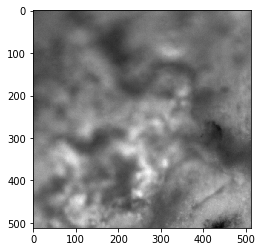

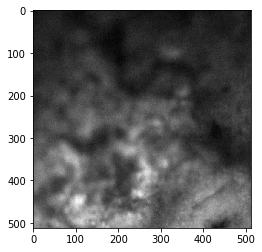

In [11]:
inp, re = load("/home/hzhuge/Documents/prostate margin/pair/05s_01_25ms_E_10_0_0_1.png")

# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp[:,:,0]/255.0,cmap='gray')
plt.figure()
plt.imshow(re[:,:,0]/255.0,cmap='gray')

In [12]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [13]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Input Pipeline

In [15]:
datadir='/home/hzhuge/Documents/prostate margin/pair'
#datadir='/home/hzhuge/Downloads/1072case/'
PATH=os.path.join(datadir)

train_dataset = tf.data.Dataset.list_files(PATH+'/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset

<DatasetV1Adapter shapes: ((None, 512, 512, 1), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>

In [16]:
datadir_test='/home/hzhuge/Documents/prostate margin/pair'
#datadir='/home/hzhuge/Downloads/1072case/'
PATH_test=os.path.join(datadir_test)
test_dataset = tf.data.Dataset.list_files(PATH_test+'/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<DatasetV1Adapter shapes: ((None, 512, 512, 1), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [17]:
OUTPUT_CHANNELS =1

In [18]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [19]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [20]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
#     tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
#                                     padding='same',
#                                     kernel_initializer=initializer,
#                                     use_bias=False))
           tf.keras.layers.UpSampling2D(size=(2,2), interpolation='nearest') )

  result.add(
      tf.keras.layers.Conv2D(filters, size,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))
    
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [21]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


In [22]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    downsample(512, 4)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4),  
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  
  init=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='nearest')
  last=tf.keras.layers.Conv2D(OUTPUT_CHANNELS,4,padding='same',kernel_initializer=initializer,activation='tanh')  
    
#   last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2,
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='tanh') # (bs, 256, 256, 4)

#   concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[512,512,1])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    #x = concat([x, skip])
    x = tf.keras.layers.Concatenate()([x, skip])
  x = init(x)
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

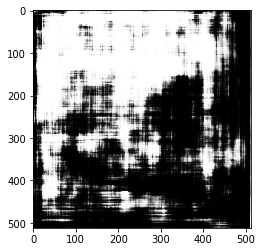

In [23]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
gen_output = generator(inp[tf.newaxis,...], training=False)

#plt.imshow(gen_output[0,...])
plt.imshow(gen_output[0,:,:,0],cmap='gray')

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [24]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
  
  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
  down4 = downsample(512, 4)(down3)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

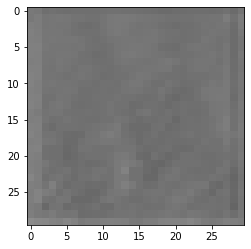

In [25]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='gray')

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [26]:
LAMBDA = 100

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [29]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints (Object-based saving)

In [31]:
checkpoint_path = '/home/hzhuge/Documents/prostate margin/checkpoints_checkboard'
#checkpoint_path = '/home/hzhuge/Downloads/1072case/training_checkpoints'
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path,max_to_keep=2000)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* This entire procedure is shown in the images below.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


---


![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**

In [32]:
EPOCHS = 1000


In [35]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))
  

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

#   import random 
#   import os 
  
 

#   r1 =33

 
#   wide=test_input[0]
#   wide=wide[:,:,0]* 0.5 + 0.5
#   filename1="%d_8_input.jpg" %(r1) 
#   plt.imsave(filename1, wide,cmap='gray')
    
#   wide=test_input[0]
#   wide=wide[:,:,1]* 0.5 + 0.5
#   filename1="%d_9_input.jpg" %(r1) 
#   plt.imsave(filename1, wide,cmap='gray')
  
#   wide=test_input[0]
#   wide=wide[:,:,2]* 0.5 + 0.5
#   filename1="%d_10_input.jpg" %(r1) 
#   plt.imsave(filename1, wide,cmap='gray')

#   target=tar[0]
#   target=target[:,:,0]* 0.5 + 0.5
#   filename2="%d_8_target.jpg" %(r1) 
#   plt.imsave(filename2, target,cmap='gray')

#   target=tar[0]
#   target=target[:,:,1]* 0.5 + 0.5
#   filename2="%d_9_target.jpg" %(r1) 
#   plt.imsave(filename2, target,cmap='gray')

#   target=tar[0]
#   target=target[:,:,2]* 0.5 + 0.5
#   filename2="%d_10_target.jpg" %(r1) 
#   plt.imsave(filename2, target,cmap='gray')

#   pred=prediction[0]
#   pred=pred[:,:,0]* 0.5 + 0.5
#   filename3="%d_8_prediction.jpg" %(r1) 
#   plt.imsave(filename3, pred,cmap='gray')
  
#   pred=prediction[0]
#   pred=pred[:,:,1]* 0.5 + 0.5
#   filename3="%d_9_prediction.jpg" %(r1) 
#   plt.imsave(filename3, pred,cmap='gray')\
  
#   pred=prediction[0]
#   pred=pred[:,:,2]* 0.5 + 0.5
#   filename3="%d_10_prediction.jpg" %(r1) 
#   plt.imsave(filename3, pred,cmap='gray')
  

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    im=display_list[i]
    img=im[:,:,0] * 0.5 + 0.5
    plt.imshow(img,cmap='gray')
    
    plt.axis('off')
  plt.show()

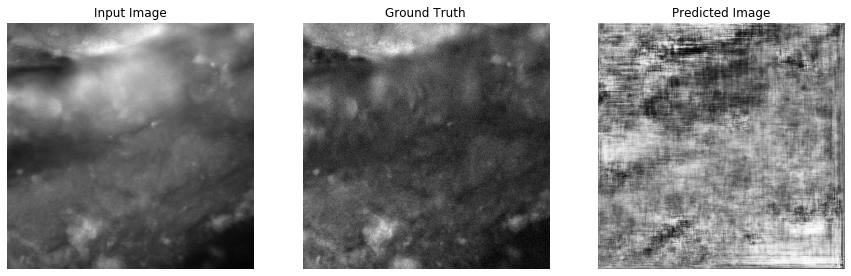

In [39]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [37]:
import datetime
log_dir="/home/hzhuge/Documents/prostate margin/logs/"

summary_writer = tf.summary.create_file_writer(
       log_dir  + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target,epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
  

In [41]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(1,epochs):
    ckpt.restore(ckpt_manager.latest_checkpoint)
   
    if ckpt_manager.latest_checkpoint:
          print("Restored from {}".format(ckpt_manager.latest_checkpoint))
    else:
          print("Initializing from scratch.")
            
    start = time.time()
    
    display.clear_output(wait=True)
    
     # Test on the same image so that the progress of the model can be 
    # easily seen.
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)
    
    
    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    
   

    # saving (checkpoint) the model every 50 epochs
    if (epoch + 1) % 30 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

   

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

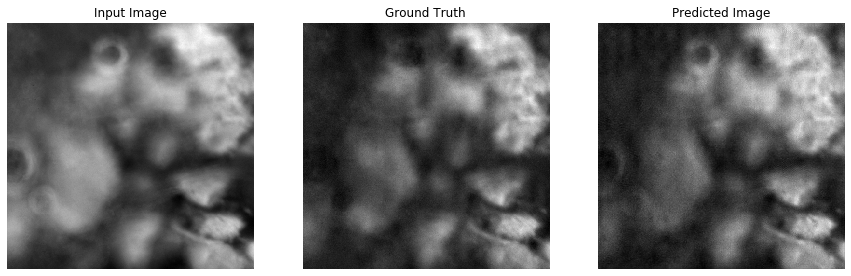

Epoch:  551
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........

KeyboardInterrupt: 

In [42]:
fit(train_dataset, EPOCHS, test_dataset)

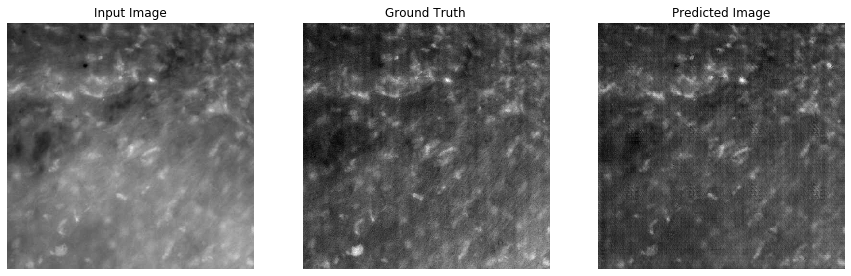

Epoch:  62
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................................................................

KeyboardInterrupt: 

In [72]:
fit(train_dataset, EPOCHS, test_dataset)

## Restore the latest checkpoint and test

In [43]:
!ls {checkpoint_path} 
checkpoint_path

ls: cannot access '/home/hzhuge/Documents/prostate': No such file or directory
ls: cannot access 'margin/checkpoints_checkboard': No such file or directory


'/home/hzhuge/Documents/prostate margin/checkpoints_checkboard'

In [44]:
# restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
ckpt.restore(ckpt_manager.latest_checkpoint)


## Generate using test dataset

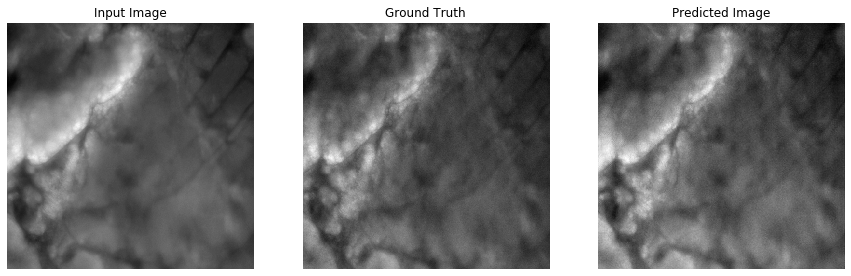

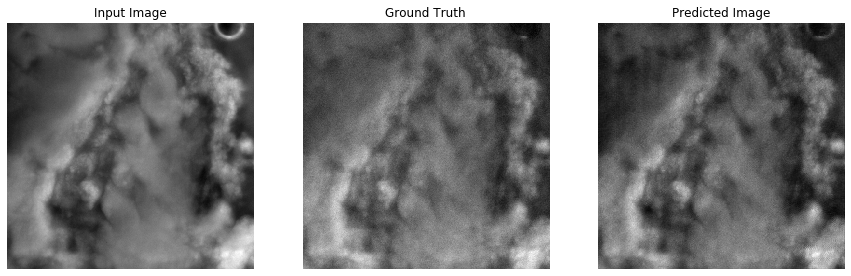

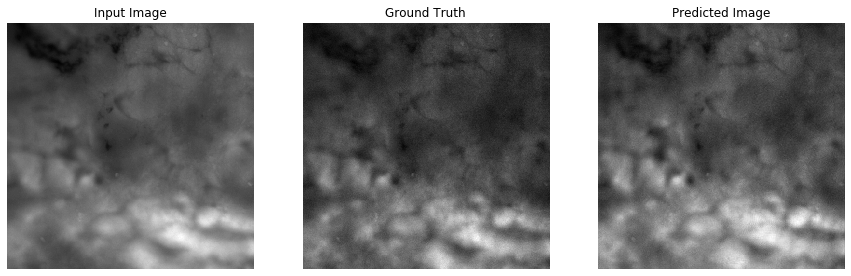

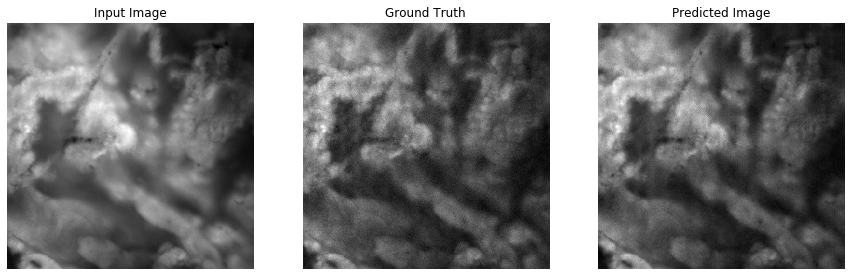

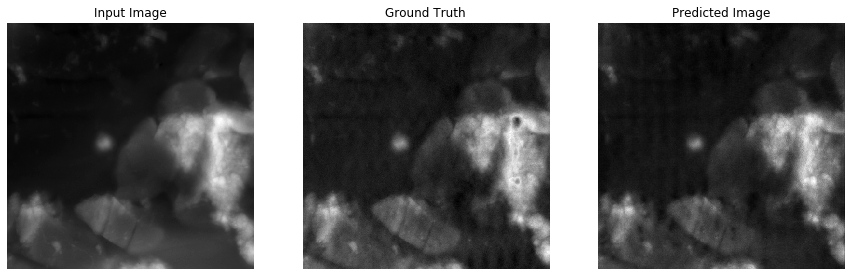

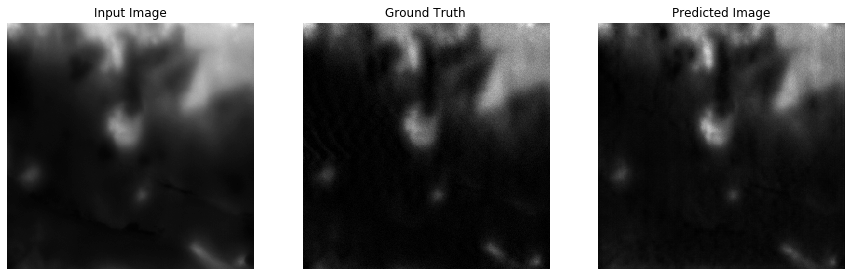

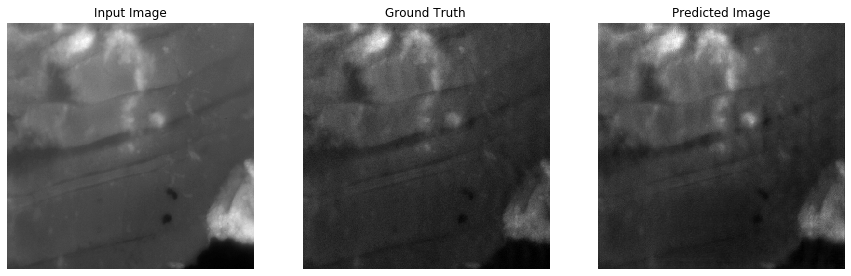

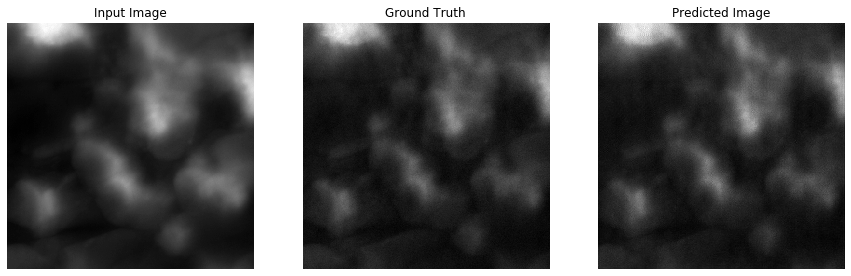

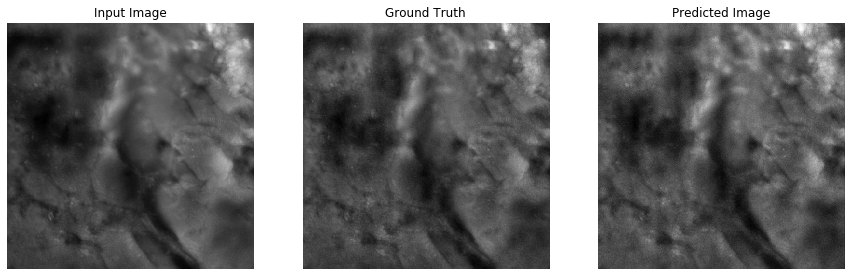

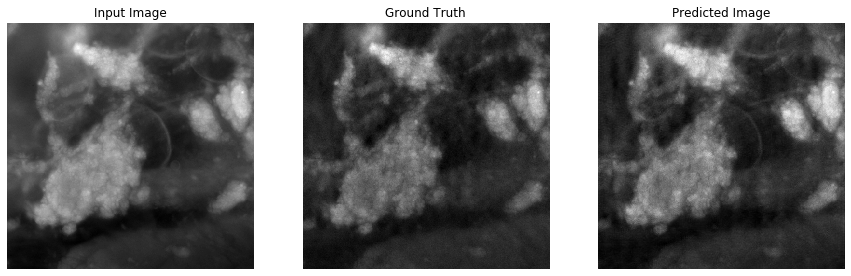

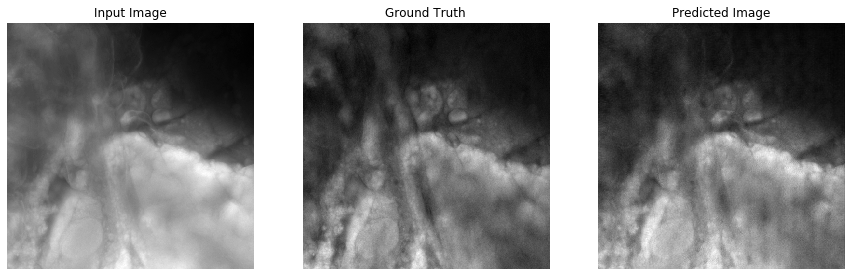

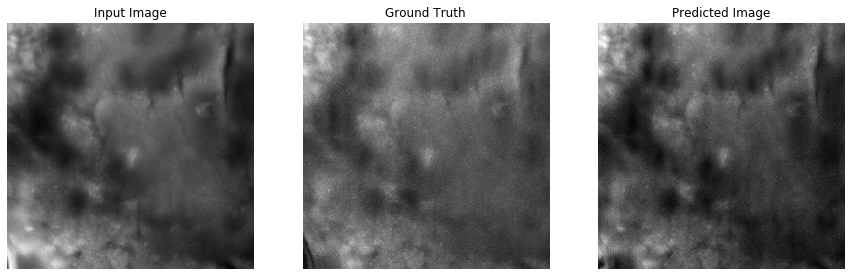

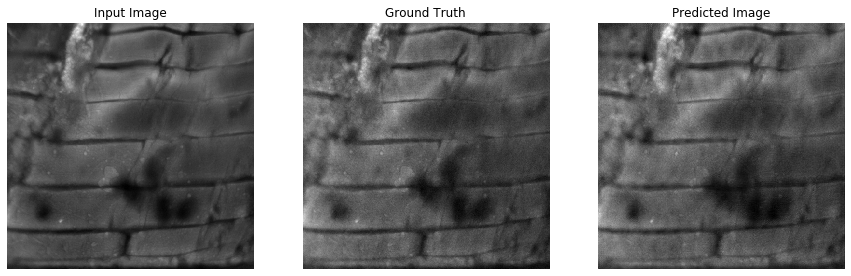

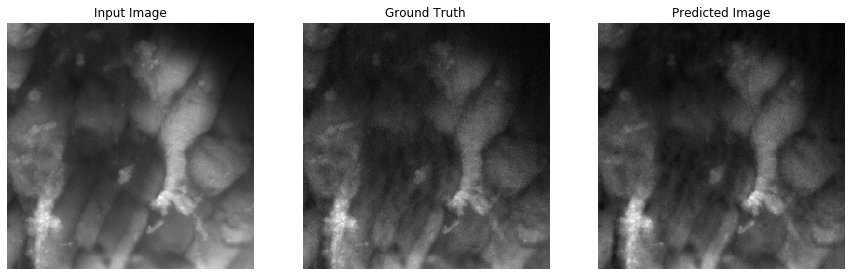

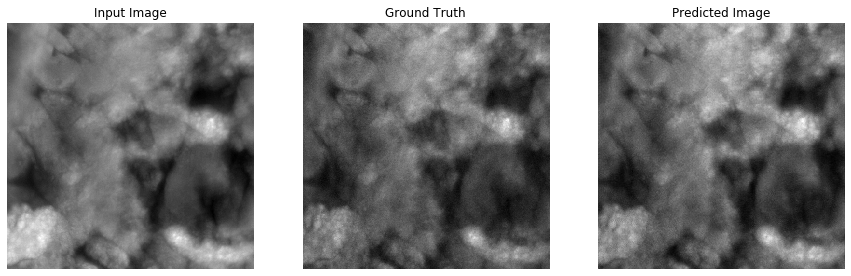

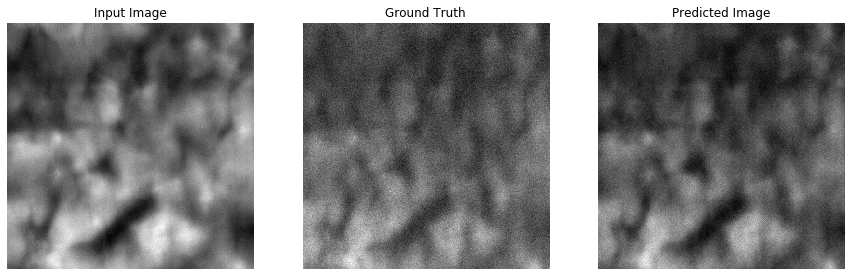

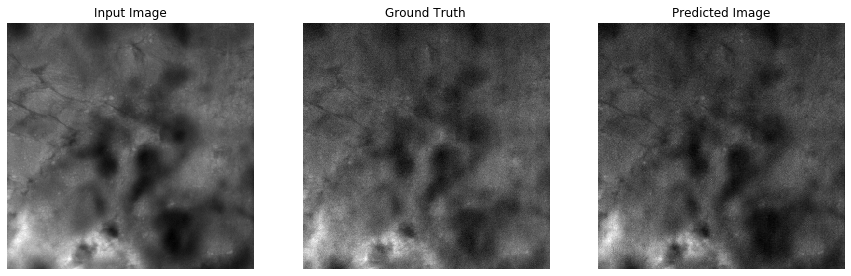

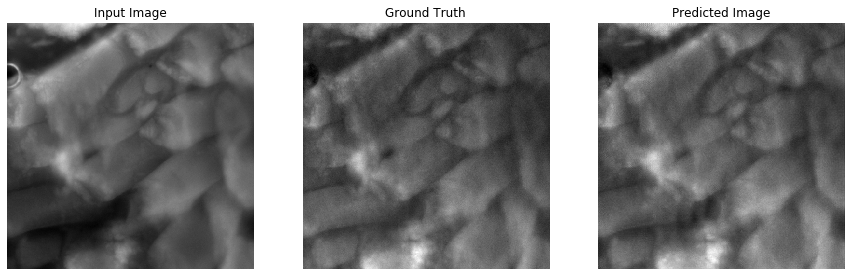

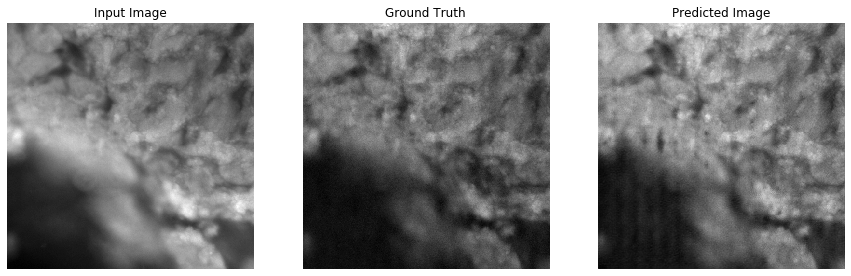

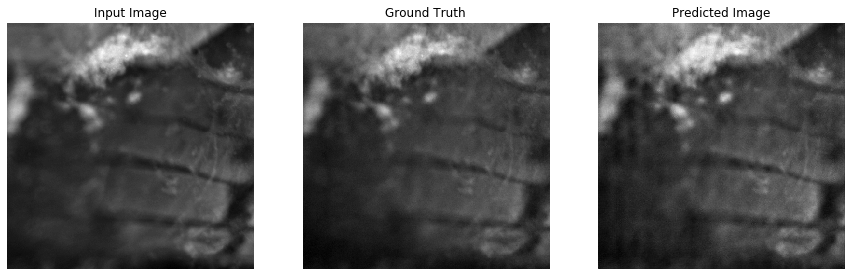

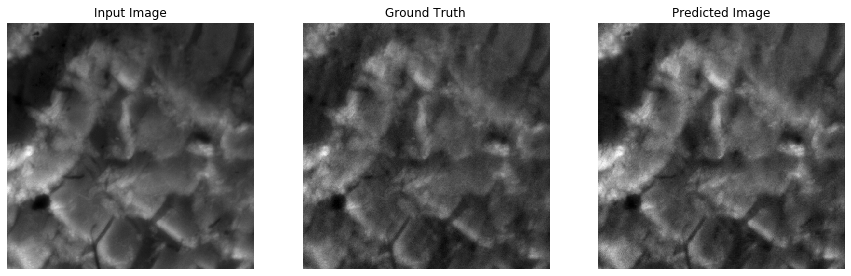

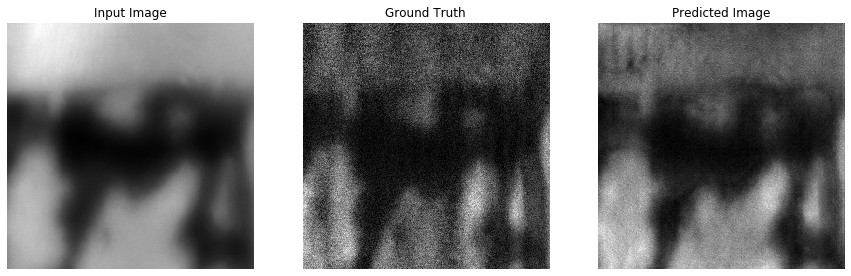

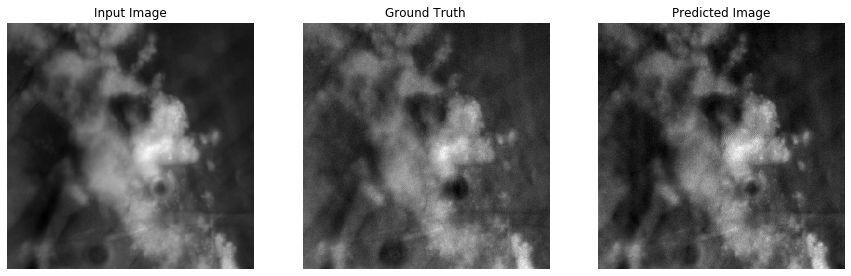

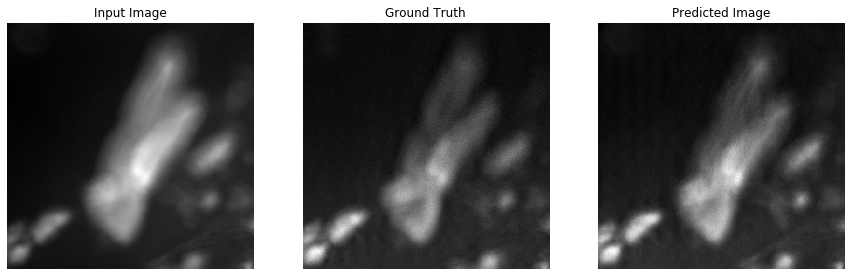

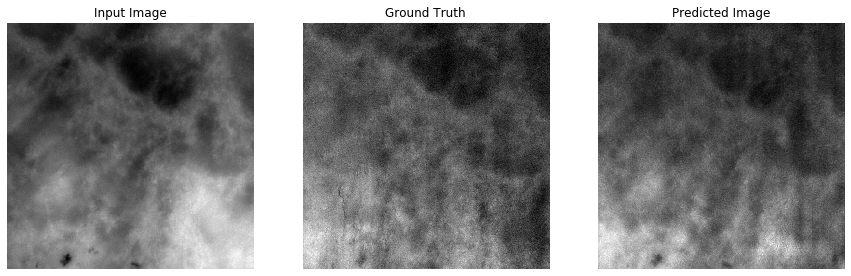

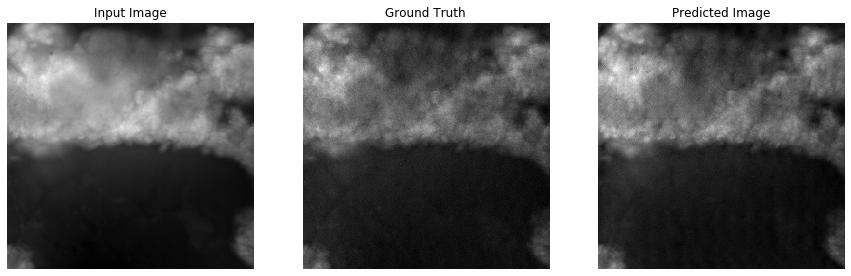

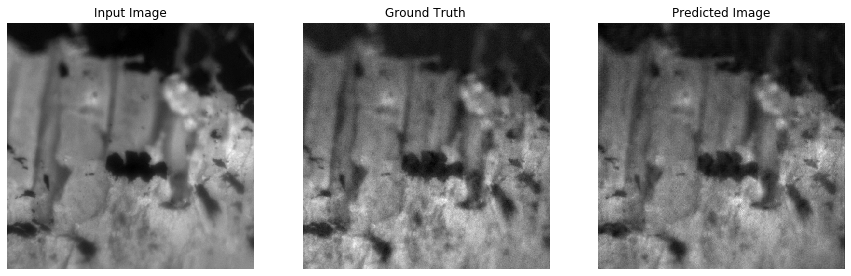

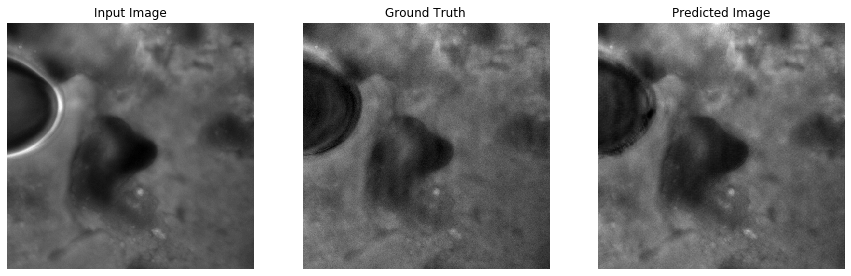

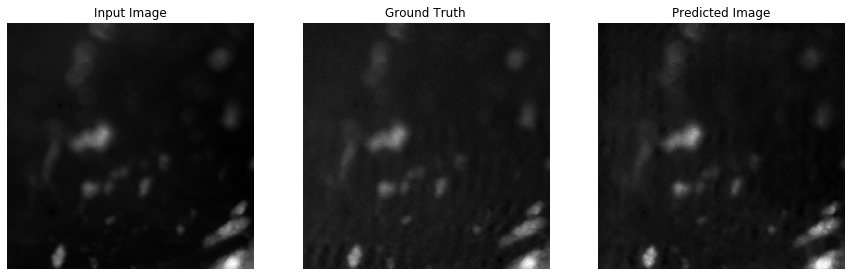

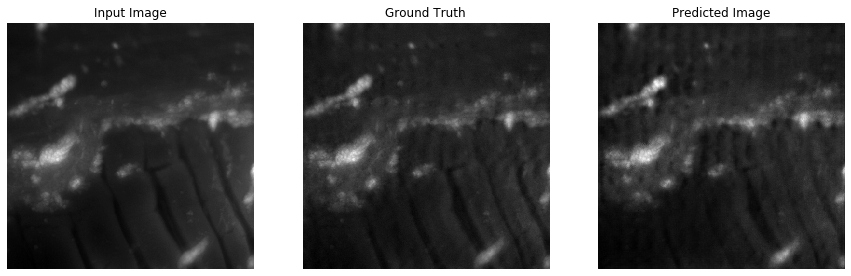

In [45]:
for example_input, example_target in test_dataset.take(30):
  generate_images(generator, example_input, example_target)


## generate test images

In [72]:
datadir_test='/home/hzhuge/Documents/prostate margin/test'
#datadir='/home/hzhuge/Downloads/1072case/'
PATH_test=os.path.join(datadir_test)
test_dataset_name = tf.data.Dataset.list_files(PATH_test+'/*.png',shuffle=False)
test_dataset = test_dataset_name.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<DatasetV1Adapter shapes: ((None, 512, 512, 1), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>

In [73]:
import re

subname=list()

for filename in test_dataset_name:
    
  fname=filename.numpy().decode('utf-8')
  res=re.split("[/.]",fname)[-2]
  subname.append(res)  

In [76]:
def generate_dataset(model, test_input, tar,subname):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  #plt.figure(figsize=(15,15))
  

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['InputImage', 'GroundTruth', 'PredictedImage']
  directory = r'/home/hzhuge/Documents/prostate margin/results/'  
 
  for i in range(3):
        im=display_list[i]
        img=im[:,:,0] * 0.5 + 0.5
        
       
        filename_total=subname+'_'+title[i]+'.png' 
        
        plt.imsave(os.path.join(directory,filename_total), img,cmap='gray')

In [77]:
i=0
for example_input, example_target in test_dataset:
     generate_dataset(generator, example_input, example_target,subname[i])
     i=i+1   